# Natural Language Processing with Disaster Tweets
**By Thanh Son Nghiem & Minh Kien Nguyen**

**Introduction**

In general, social networks have evolved beyond their original purpose as a communication platforms. In times of emergency, especially, they often become the first sources of information for the vast majority of the population, given that contents on social network platforms are created directly by their users, who may even be observing a disaster in real time, and thus underlie no editorial standards or restrictions. Twitter represents one good example of such places where the minimal delay between the birth of a disaster and its first announcement could have a real contribution in the preserving of human life.

The purpose of this project is to develop a natural language processing model for the classification of tweets into two categories: disaster tweets (1) and non-disaster tweets (0). Fortunately, we had access to a dataset of roughly 10,000 tweets, collected by the company “figure-eight” and published on Kaggle. The dataset is split into a train set with 7,000 samples that were hand classified by the creator, and a test set with 3,000 samples that were not classified. Because of this, we have decided to hand classify the test set ourselves, as well as to apply Stratified Cross Validation to the train set in order to determine the most promising combinations of classifiers and embedding techniques for the given task.

Each sample of each tweet in the dataset contains the following information in the form of strings:
* an unique ID for identification
* the text,
* optionally a keyword,
* optionally the location that tweet was sent from.

The most difficult aspect of the classification task is perhaps best described by the keywords themselves. If an average person were to classify these tweets based only on their keywords and not their full contents, he or she would most likely predict all of them to be disaster tweets. This is because all keywords, when standing alone and without context, would be interpreted negatively. For example, the tweets “Man injured in Radcliff shooting”, which reports a real disaster, and “Ben Heenan carted off the field at @Colts training camp. No word on how serious the injury is”, which reports sports news, both contain the keyword “injury”, which on its own should be interpreted negatively.

<a id='0'>Table of Contents (ToC):</a>
* <a href='#1'>1. Frame the Problem</a>
* <a href='#2'>2. Get the Data</a>
* <a href='#3'>3. Explore the Data</a>
* <a href='#4'>4. Prepare the Data</a>
* <a href='#5'>5. Shortlist Promising Models</a>
* <a href='#6'>6. Test the Best Model</a>
* <a href='#7'>7. Discuss the Results</a>

---
<a id='1'></a>
## 1. Frame the Problem

### 1.1 Define the objective in business terms

* *The primary goal of this Jupyter Notebook project is to build machine learning models that predict which Tweets are about real disasters and which ones are not.*

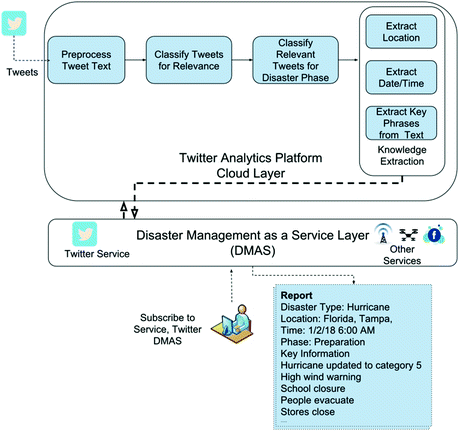

* The scope of this project lies mostly within the first two blocks of the Twitter Analytics Platform (i.e. Preprocess Tweet Text & Classify Tweets for Relevance). The output of the models (classification results of the given Tweets) will be used as input for the third block (Classify Relevant Tweets for Disaster Phase).

### 1.2 Categorize the problem

* The problem is categorized as a Supervised, Batch, Model-based Learning Problem.

### 1.3 Choose evaluation metric

* The F-Beta-Score will be used to evaluate the performance of the models.

* The F-Beta-Score weighs recall more than precision by a factor of *Beta*.

* In this project *Beta* will be set equal to 0.5, as precision is more important than recall in the previous diagram.

### 1.4 Import third party resources

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import string
import os
import re
import random
import math
from datetime import datetime

In [ ]:
import nltk
import nltk.tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [ ]:
STOPWORDS=set(stopwords.words('english'))

In [ ]:
import spacy
# !python -m spacy download en_core_web_sm
import en_core_web_sm

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn import manifold

In [ ]:
from tensorflow.keras import preprocessing as kprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# !pip install torchvision
# !pip install transformers

In [ ]:
import torch
import transformers
import tensorflow as tf

In [ ]:
# !python --version

In [ ]:
# # Check Pytorch, transformers and tensorflow version
# print("PyTorch:",torch.__version__)
# print("transformers",transformers.__version__)
# print("tensorflow:",tf.__version__)

In [ ]:
#  tf.test.is_built_with_cuda()

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

In [ ]:
# !pip install gensim
# !pip install manifold

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim.models import Word2Vec
import gensim.downloader as gensim_api

<a href='#0'>Back to ToC</a>

---
<a id='2'></a>
## 2. Get the Data

### 2.1 Find and document where to get the data

* The dataset used in this Notebook was created by the company *figure-eight* and was made widely known to the public by *Kaggle*, who uses it as training and test sets for their Getting Started Prediction Competition "Natural Language Processing with Disaster Tweets".

* Link to the *Kaggle* training and test datasets as well as their description can be found [here](https://www.kaggle.com/c/nlp-getting-started/data).

* Note that the *Kaggle* test set ```test.csv``` was not labeled. The labeling of the test set was done manually by the creators of this Notebook and saved separately in the file ```labeled_test.csv```.

### 2.2 Get and take a quick look at the data

In [ ]:
# Read the datasets into DataFrames
train_df = pd.read_csv('../input/disaster-tweets/train.csv',sep=",", header="infer")
test_df = pd.read_csv('../input/disaster-tweets/test.csv',sep=",", header="infer")
labeled_test_df = pd.read_csv('../input/disaster-tweets/labeled_test.csv',sep=",", header="infer")

Data Format Description:
* ```id``` - a unique identifier for each tweet
* ```text``` - the text of the tweet
* ```location``` - the location the tweet was sent from (may be blank)
* ```keyword``` - a particular keyword from the tweet (may be blank)
* ```target``` - this denotes whether a tweet is about a real disaster (1) or not (0)

In [ ]:
# Print a concise summary of the training set
train_df.info()

In [ ]:
# Print a concise summary of the unlabeled test set
test_df.info()

In [ ]:
# Print a concise summary of the labeled test set
labeled_test_df.info()

In [ ]:
# Calculate the number and the proportion of Disaster Tweets and Non-Disaster Tweets in the training set
train_class_distrb = train_df["target"].value_counts()
print(train_class_distrb)
print(train_class_distrb/len(train_df))

# Visualize the results found
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
sns.barplot(x=train_class_distrb.index, y=train_class_distrb, ax=axes[0])
axes[0].set_ylabel('#Tweets')
axes[1].pie(train_class_distrb,
            labels=['Non-Disaster', 'Disaster'],
            autopct='%1.2f%%',
            explode=(0.03, 0),
            startangle=90)
fig.suptitle('Class Distribution of the Tweets (training set)', fontsize=16)
plt.show()

In [ ]:
# Calculate the number and the proportion of Disaster Tweets and Non-Disaster Tweets in the labeled test set
labeled_test_class_distrb = labeled_test_df["target"].value_counts()
print(labeled_test_class_distrb)
print(labeled_test_class_distrb/len(labeled_test_df))

# Visualize the results found
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))
sns.barplot(x=labeled_test_class_distrb.index, y=labeled_test_class_distrb, ax=axes[0])
axes[0].set_ylabel('#Tweets')
axes[1].pie(labeled_test_class_distrb,
            labels=['Non-Disaster', 'Disaster'],
            autopct='%1.2f%%',
            explode=(0.03, 0),
            startangle=90)
fig.suptitle('Class Distribution of the Tweets (labeled test set)', fontsize=16)
plt.show()

<a href='#0'>Back to ToC</a>

---
<a id='3'></a>
## 3. Explore the Data

The purpose of data exploration is to determine features to be extracted from tweets, which represent potentially effective discriminators for the given classification task.

### 3.1 Create a copy of the data for exploration

In [ ]:
eda_train = train_df.copy()

### 3.2 Check for discrepancy between duplicated Tweets

* We have discovered that there are tweets which appear more than once in the train set but were labeled differently in each appearance. This is understandable, since the train set was classified manually, but not ignorable, as they obviously affect the training process negatively.
* There are 18 unique Tweets in the training set which are labeled differently in their duplicates.
* Tweets with two unique ```target``` values must be relabeled.

In [ ]:
# Find the number of labels each Tweet has
label_count_of_each_Tweet = eda_train[["text", "target"]].groupby(['text']).nunique().sort_values(by='target', ascending=False)

# Find the mislabeled Tweets
mislabeled_tweets = label_count_of_each_Tweet[label_count_of_each_Tweet['target'] == 2]
display(mislabeled_tweets)

### 3.3 Identify features of interest

Now that the accuracy of the train set has been guaranteed, it’s time to begin with the actual data exploration.

* Features that may yield valuable information **BEFORE** Data Preprocessing:
  * URL count per Tweet
  * Punctuation count per Tweet
  * Hashtag count per Tweet
  * Mention count per Tweet
  * Most common Hashtags
  * Most common Keywords
  * Most common Locations
  * Most common Named Entity Types
  

* Features that may yield valuable information **AFTER** Data Preprocessing:
  * Character count per Tweet
  * Word count per Tweet
  * Unique word count per Tweet
  * Average word length per Tweet
  * Most common N-grams

A feature is then considered to be a potential discriminator for the given classification task, in case there is a recognizable pattern in this feature which distinct the disaster tweets from the non-disaster tweets.

### 3.4 Examine listed features and document findings

In [ ]:
def plot_count_histogram_of(feature, df):
    """
    A function that draws histograms to compare counts of the given feature per Non-Disaster- and per Disaster Tweet
    """
    
    # Get Non-Disaster & Disaster Tweets from the given DataFrame
    df_no = df[df["target"]==0]
    df_yes = df[df["target"]==1]
    
    # Draw count histograms for both Tweet classes, in which the x-Axis depicts the given feature
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True, sharex=True)
    sns.histplot(data=df_no, x=feature, ax=axes[0], color='steelblue')
    sns.histplot(data=df_yes, x=feature, ax=axes[1], color='darkorange')
    
    # Set layout and labels of the drawn histograms
    axes[0].set_ylabel('#Tweets')
    axes[0].set_xlabel(feature + " per Tweet")
    axes[0].set_title('Non-Disaster Tweets')
    axes[1].set_xlabel(feature + " per Tweet")
    axes[1].set_title('Disaster Tweets')
    fig.suptitle(feature + ' per Tweet', fontsize=20)
    fig.tight_layout()

In [ ]:
def get_N_most_common_(feature, df, target, N):
    """
    A function that:
    - calculates the frequency distribution of those elements of the given feature which are labeled as the given target
    - then returns the N most common ones of those elements
    """
    
    # If the given feature is either "hashtag", "named entity type" or "without stopwords"
    if (feature == "hashtag") or (feature == 'named entity type') or (feature == 'without stopwords'):
        
        # Convert each element into a string, then lowercase, clean and tokenize each element
        txt = df[df['target']==target][feature].str.lower().str.replace(r'\|', ' ', regex=True).str.cat(sep=' ')
        words = nltk.tokenize.word_tokenize(txt)
        
        # Calculate the frequency of each token except for those categorized as stopwords, 'None' or punctuation
        words_except_stop_dist = nltk.FreqDist(w for w in words if (w not in STOPWORDS) and (w is not None) and (w != ','))
    
    # else
    else:
        
        # Convert each element into a string, then lowercase and clean each element
        words = df[df['target']==target][feature].str.lower().str.replace('%20', ' ').astype(str)
        
        # Calculate the frequency of each token except for those categorized as stopwords, 'None' or "nan"-string
        words_except_stop_dist = nltk.FreqDist(w for w in words if (w not in STOPWORDS) and (w != "nan"))
         
    result = pd.DataFrame(words_except_stop_dist.most_common(N), columns=[feature, 'Frequency'])
    return result

In [ ]:
def plot_N_most_common_(feature, df, N):
    """
    A function that draws plots showing the N most common elements of the given feature in Non-Disaster & Disaster Tweets
    """
    
    # Get the N most common elements of the given feature in Non-Disaster & Disaster Tweets
    df_no = get_N_most_common_(feature, df, 0, N)
    df_yes = get_N_most_common_(feature, df, 1, N)
    
    # Draw plots showing the N most common elements of the given feature in Non-Disaster & Disaster Tweets
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharex=True)
    sns.barplot(x=df_no.iloc[:,1], y=df_no.iloc[:,0], ax=axes[0], color='steelblue')
    sns.barplot(x=df_yes.iloc[:,1], y=df_yes.iloc[:,0], ax=axes[1], color='darkorange')
    
    # Set layout and labels of the drawn histograms
    axes[0].set_ylabel('Most common ' + feature)
    axes[0].set_xlabel("Count")
    axes[0].set_title('Non-Disaster Tweets')
    axes[1].set_ylabel('Most common ' + feature)
    axes[1].set_xlabel("Count")
    axes[1].set_title('Disaster Tweets')
    fig.suptitle("The " + str(N) + ' most common ' + feature +"s", fontsize=20)
    fig.tight_layout()
    
    # Add legends in case of the feature 'named entity type'
    if feature == 'named entity type':
        patch1 = mpatches.Patch(label='PERSON : People, including fictional')
        patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
        patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
        patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
        patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
        patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
        patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
        patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
        patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
        patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
        patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
        patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
        patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
        patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
        patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')
        
        plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15],
                   bbox_to_anchor=(1.05, 0.85), 
                   loc='upper left', 
                   borderaxespad=0.)

        plt.show()

#### URL count per Tweet

* The feature "URL count per Tweet" is a potential discriminator for the given classification task.
* The Disaster Tweets tend to have at least one URL in them, while the Non-Disaster ones are likely to have none.

In [ ]:
# Calculate the number of URLs in each Tweet
eda_train['url count'] = eda_train['text'].apply(lambda x: len([word for word in str(x).lower().split(" ") if 'http://' in word or 'https://' in word]))

In [ ]:
plot_count_histogram_of('url count', eda_train)

#### Punctuation count per Tweet

* The feature "Punctuation count per Tweet" is not a good discriminator for the given classification task.
* Despite the difference between the numbers of Disaster and Non-Disaster Tweets in the range from zero to four punctuation marks per Tweet, overall the distributions of Tweets from both label classes over the punctuation count per Tweet are mostly similar.

In [ ]:
string.punctuation

In [ ]:
# Calculate the number of punctuation marks in each Tweet
eda_train['punctuation count'] = eda_train['text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

In [ ]:
plot_count_histogram_of('punctuation count', eda_train)

#### Hashtag count per Tweet

* The feature "Hashtag count per Tweet" is not a good discriminator for the given classification task.
* There is no recognizable pattern in this feature to differentiate between Disaster and Non-Disaster Tweets. 
* Note that the hashtags can still be used for further data analysis and thus should not be removed. To get hashtag contents, a necessary transformation is to remove the punctuation mark '#' in the Tweet text.

In [ ]:
# Calculate the number of hashtags in each Tweet
eda_train['hashtag count'] = eda_train['text'].apply(lambda x: len([char for char in str(x) if char == "#"]))

In [ ]:
plot_count_histogram_of('hashtag count', eda_train)

#### Mention count per Tweet

* The feature "Mention count per Tweet" is not a good discriminator for the given classification task.
* There is no recognizable pattern in this feature to differentiate between Disaster and Non-Disaster Tweets.
* Note that the mentions made in each Tweet can still contribute to further data analysis and thus should not be removed. To get mentioned entities, a necessary transformation is to remove the punctuation mark '@' in the Tweet text.

In [ ]:
# Calculate the number of mentions in each Tweet
eda_train['mention count'] = eda_train['text'].apply(lambda x: len([char for char in str(x) if char == "@"]))

In [ ]:
plot_count_histogram_of('mention count', eda_train)

#### Most common Hashtags

* The feature 'Most common Hashtags' is not a good discriminator for the given classification task.
* Only half of the most common hashtags appearing in Disaster Tweets are directly linked to the disasters reported (e.g. earthquake, isis, abstorm, disaster, wildfire, terrorism). In addtion, there are many hashtags in common between the two Tweet classes, especially those suggesting news postings/publishing (i.e. nowplaying, news, breaking, worldnews). These would most likely reduce the performance of classifiers used later.

In [ ]:
def find_hashtags(tweet):
    """
    A function that returns all hashtags in the given Tweet
    """
    
    # Regex for Tweet Hashtag can be found here: https://stackoverflow.com/a/54147208
    return ", ".join([match.group(0)[1:] for match in re.finditer(r"\B#\w*[a-zA-Z]+\w*", tweet)]) or None

In [ ]:
# Find the hashtags in each Tweet
eda_train['hashtag'] = eda_train["text"].apply(lambda x: find_hashtags(x))

In [ ]:
plot_N_most_common_("hashtag", eda_train, 20)

#### Most common Keywords

* The feature 'Most common Keywords' is not a good discriminator for the given classification task.
* The most common keywords in Non-Disaster Tweets highly suggest that there are disasters involved, which is not true.

In [ ]:
plot_N_most_common_("keyword", eda_train, 20)

#### Most common Locations

* The feature 'Most common Locations' is not a good discriminator for the given classification task. 
* No clear patterns can be used to properly distinguish between the two Tweet classes.

In [ ]:
plot_N_most_common_("location", eda_train, 20)

#### Most common Named Entity Types
* The feature 'Most common Named Entity Types' is not a good discriminator for the given classification task. 
* No clear patterns can be used to properly distinguish between the two Tweet classes.

In [ ]:
# load the english pipeline
nlp = en_core_web_sm.load()

In [ ]:
def get_named_entity_types(text):
    """
    A function that takes a Tweet text and returns a list of named entity types contained in that text
    """
    
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

In [ ]:
def list2str(list):
    """
    A function that converts a list of strings into a single string, separating the old strings by commas
    """
    
    return ', '.join(list)

In [ ]:
# Find the named entity types in each Tweet
eda_train['named entity type'] = eda_train['text'].apply(get_named_entity_types).apply(list2str)

In [ ]:
plot_N_most_common_("named entity type", eda_train, 20)

**Summary:** Of all those features listed above, only the URL count per tweet represents a potential discriminator. Disaster tweets most likely have at least one URL (i.e. link to a news website which reports on the incident), while non-disaster tweets most likely have none. In the other listed features, no difference can be recognized between two categories.

### 3.5 Identify promising transformations to apply

URLs, HTML tags, emojis and punctuation marks, which appears a lot in tweets but carry no real meanings, were removed from the train dataset. For each tweet, a list of tokens was created using the tokenizer imported from the nltk-package. In order to further clean and prepare the train data set for following steps, we also transformed all tokens to lower case and removed all stopwords, which also appear a lot but carry little meanings. We then applied part-of-speech-tagging to the cleaned tokens and, finally, lemmatized them.

We would like to summarize our steps to preprocess the data as follows:
* Handle mislabeled samples (for training set only)
* Clean the Tweet base texts
  * Remove URLs
  * Remove HTML tags
  * Remove emojis
  * Remove punctuation marks
* Tokenize cleaned texts
* Lowercase cleaned tokenized texts
* Remove stopwords
* Apply Part-of-Speech tagging
* Convert POS tags to Wordnet format
* Apply Wordnet lemmatizer

<a href='#0'>Back to ToC</a>

---
<a id='4'></a>
## 4. Prepare the Data

Overview:
* Copying Data (4.0)
* Data Transforming
  * Write functions for all data transformations that will be applied (4.1 - 4.8)
  * Apply written transformation functions (4.9)
* Post-Data-Transforming Analysis (4.10)
* Data Preprocessing (4.11)

### 4.0 Make copies of the data

In [ ]:
# DPP stands for Data PreProcessing
dpp_train = train_df.copy()
dpp_test = test_df.copy()

### 4.1 Handle mislabeled samples (for training set only)

* Mislabeled Tweets will be relabeled based on their contents by the creators of this Notebook.

In [ ]:
dpp_train["relabeled target"] = dpp_train["target"].copy()

# Tweets that will be relabeled as Disaster ones
relabeled_as_disaster_Tweets = ['.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4',
                                'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring',
                                "Caution: breathing may be hazardous to your health."]

# Relabel the mislabeled Tweets
for tweet in mislabeled_tweets.index.tolist():
    if tweet in relabeled_as_disaster_Tweets:
        dpp_train.loc[dpp_train['text'] == tweet, "relabeled target"] = 1
    else:
        dpp_train.loc[dpp_train['text'] == tweet, "relabeled target"] = 0
        
dpp_train.head(2)

### 4.2 Clean the Tweet base texts

In [ ]:
def remove_URL(text, decided_to_remove=True):
    """
    A function that removes URLs from the given text
    """
    
    if decided_to_remove:
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', text)
    else:
        return text

In [ ]:
def remove_html(text, decided_to_remove=True):
    """
    A function that removes HTML tags from the given text
    """
    
    if decided_to_remove:
        html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        return html.sub(r'',text)
    else:
        return text

In [ ]:
def remove_emoji(text, decided_to_remove=True):
    """
    A function that removes Emojis from the given text
    """
    
    if decided_to_remove:
        # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        emoji_pattern = re.compile(pattern = "["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [ ]:
def remove_punct(text, decided_to_remove=True):
    """
    A function that removes punctuation marks from the given text
    """
    
    if decided_to_remove:
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table)
    else:
        return text

### 4.3 Tokenize cleaned texts

* The function ```word_tokenize()``` imported from the module ```nltk.tokenize``` will be used to tokenize cleaned texts.
* The returned result of ```word_tokenize()``` applied on a Tweet text is a *list of word tokens*.

In [ ]:
from nltk.tokenize import word_tokenize

### 4.4 Lowercase cleaned tokenized texts

In [ ]:
def lowercase(token_list, decided_to_lower=True):
    """
    A function that lowercases all tokens in the given token list
    """
    
    if decided_to_lower:
        return [token.lower() for token in token_list]
    else:
        return token_list

### 4.5 Remove stopwords

In [ ]:
def remove_stopwords(token_list, decided_to_remove=True):
    """
    A function that removes stopwords from the given token list
    """
    
    if decided_to_remove:
        return [token for token in token_list if token not in STOPWORDS]
    else:
        return token_list        

### 4.6 Apply Part-of-Speech tagging

* The function ```pos_tag()``` imported from the module ```nltk.tag``` will be used to apply POS tagging.
* The returned result of ```pos_tag()``` applied on a Tweet text is a *list of tuples*. Each tuple contains a token and its associated POS tag.
* The meaning of each POS tag can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html):

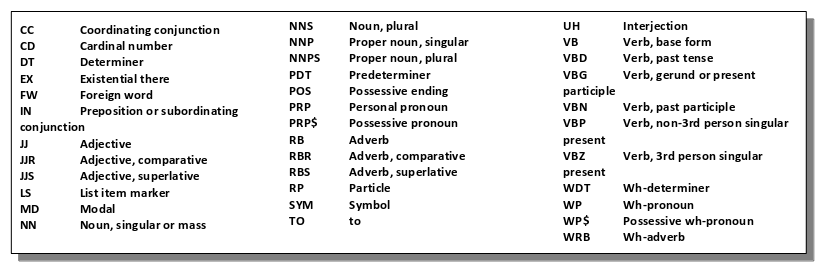

In [ ]:
from nltk.tag import pos_tag

### 4.7 Convert POS tags to Wordnet format

In [ ]:
def convert_to_wordnet(tag):
    """
    A function that converts the given (Penn Treebank) POS tag into Wordnet format
    """
        
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
def convert_POS_tags(tuple_list, decided_to_convert=True):
    """
    A function that converts all (Penn Treebank) POS tags of the given tuple list into Wordnet format
    """
        
    if decided_to_convert:
        return [(token, convert_to_wordnet(pos_tag)) for (token, pos_tag) in tuple_list]
    else:
        return tuple_list        

### 4.8 Apply Wordnet lemmatizer

In [ ]:
def lemmatize_using_wordnet(tuple_list, decided_to_lemmatize=True):
    """
    A functions that lemmatizes all tokens in the given tuple list using its associated tag and Wordnet lemmatizer
    """
    
    wnl = WordNetLemmatizer()
    if decided_to_lemmatize:
        return [wnl.lemmatize(token, tag) for token, tag in tuple_list]
    else:
        return tuple_list

### 4.9 Apply transformation functions

In [ ]:
def transform(df):
    """
    A function that applies all of the transformations declared above to the given DataFrame and returns it
    """
    
    # Clean the Tweet base texts
    df['cleaned text'] = df['text'].apply(lambda text: remove_URL(text))
    df['cleaned text'] = df['cleaned text'].apply(lambda text: remove_emoji(text))
    df['cleaned text'] = df['cleaned text'].apply(lambda text: remove_html(text))
    df['cleaned text'] = df['cleaned text'].apply(lambda text: remove_punct(text))
    
    # Tokenize cleaned texts
    df['tokenized'] = df['cleaned text'].apply(word_tokenize)
    
    # Lowercase cleaned tokenized texts
    df['lowercased'] = df['tokenized'].apply(lowercase)
    df['lowercased text'] = [' '.join(map(str, l)) for l in df['lowercased']]
    
    # Remove stopwords
    df['without stopwords'] = df['lowercased'].apply(remove_stopwords)
    df['text without stopwords'] = [' '.join(map(str, l)) for l in df['without stopwords']]
    
    # Apply Part-of-Speech tagging
    df['pos tags'] = df['without stopwords'].apply(pos_tag)
    
    # Convert POS tags to Wordnet format
    df['wordnet pos'] = df['pos tags'].apply(convert_POS_tags)
    
    # Apply Wordnet lemmatizer
    df['lemmatized'] = df['wordnet pos'].apply(lemmatize_using_wordnet)
    df['lemmatized'] = df['lemmatized'].apply(remove_stopwords)
    df['lemmatized text'] = [' '.join(map(str, l)) for l in df['lemmatized']]
    
    return df

In [ ]:
# Transform the training data

transformed_train = transform(dpp_train)
transformed_train.head(2)

In [ ]:
# Transform the test data

transformed_test = transform(dpp_test)
transformed_test.head(2)

### 4.10 Analyze transformed data

The cleaning and transformation of the dataset allowed us to analyze further interesting features, whose examination could not be objectified with the existence of URLs, emojis, stopwords, etc. These features were:
* Character count per tweet
* Word count per tweet
* Unique count per tweet
* Average word length per tweet
* Most common N-grams

In [ ]:
# Make a copy of transformed training data for further analysis
eda_transformed_train = transformed_train.copy()

#### Character count per Tweet

* The feature "Character count per Tweet" is a potential discriminator for the given classification task.
* Character counts of Disaster Tweets are especially common in the 110-115 range.
* On average Non-Disaster Tweets tend to have more characters than Disaster Tweets.

In [ ]:
# Calculate the number of characters in each Tweet
eda_transformed_train['character count'] = eda_transformed_train['cleaned text'].apply(lambda x: len(str(x)))

In [ ]:
plot_count_histogram_of('character count', eda_transformed_train)

#### Word count per Tweet

* The feature "Word count per Tweet" is not a good discriminator for the given classification task.
* Although Non-Disaster Tweets tend to have more words than Disaster ones, this is to be expected, based on the feature "character count per Tweet" above.
* Overall, the word count distribution in both classes are similar to each other to a great extent.

In [ ]:
# Calculate the number of words in each Tweet
eda_transformed_train['word count'] = eda_transformed_train['tokenized'].apply(lambda x: len(x))

In [ ]:
plot_count_histogram_of('word count', eda_transformed_train)

#### Unique word count per Tweet

* The feature "Unique word count per Tweet" is not a good discriminator for the given classification task.
* Reasons are the same as of "Word count per Tweet".

In [ ]:
def unique_word_count(token_list):
    """
    A function that returns the number of unique tokens in the given list of tokens
    """
    
    result = []
    for token in token_list:
        if token not in result:
            result.append(token)
    return len(result)

In [ ]:
# Calculate the number of unique words in each Tweet
eda_transformed_train['unique word count'] = eda_transformed_train['tokenized'].apply(unique_word_count)

In [ ]:
plot_count_histogram_of('unique word count', eda_transformed_train)

#### Average word length per Tweet

* The feature "Average word length per Tweet" is not a good discriminator for the given classification task. 
* No clear patterns can be used to properly distinguish between the two Tweet classes.

In [ ]:
# # Calculate the average word length in each Tweet
eda_transformed_train['average word length'] = eda_transformed_train['character count'] / eda_transformed_train['word count']

In [ ]:
plot_count_histogram_of('average word length', eda_transformed_train)

**Summary:** Some of these features also represent potential discriminators for the given classification task. The character count per tweet is one of them: disaster tweets with between 110 and 115 characters are most common, while non-disaster tweets can have anywhere from as few as 30 to as many as 135 characters. Other than that, non-disaster tweets tend to have more characters than disaster tweets. It is therefore expected, that non-disaster tweets have greater word counts and unique word counts per tweets than disaster-tweets. The differences are however minimal and these features stay similar to a great extent between the two categories, meaning they do not represent good discriminators.

#### Most common N-grams

* The feature "Most common N-grams" can be used to create potential discriminators for the given classification task.
* The greater the number N, the more disaster-relevant the most common N-grams in Disaster Tweets become, but also the less frequent they are in Disaster Tweets. This means that if we were to use "Most common N-grams" as a potential indicator of Disaster Tweets (for example) by adding an attribute asking if each Tweet has one of the most common N-grams in Disaster Tweets, many Disaster Tweets would be labeled "0" or "No", which would affect the classification process negatively.
* To solve this problem, later during Data Preprocessing we will add and use new attributes called "disaster ngram count" and "non disaster ngram count", which approximates the number of disaster-relevant and -irrelevant N-grams each Tweet has respectively. 
  * The disaster-relevant N-grams will be found by looking for the N-grams in Disaster Tweets which are also parts (substrings) of any N+2-gram with more than one occurence in Disaster Tweets. 
  * The disaster-irrelevant N-grams will be found by looking for the N-grams in Non-Disaster Tweets which are also parts (substrings) of any N+2-gram in Non-Disaster Tweets. 
* Assumptions: Starting from N = 4
  * All N-grams in Disaster Tweets with more than one occurence are strictly disaster-relevant (e.g.“suicide bomber detonated bomb").
  * All N-grams in Non-Disaster Tweets are strictly disaster-irrelevant (e.g. “china’s stock market crash”).

In [ ]:
def get_N_most_common_ngram(feature_ngram, df, target, N):
    """
    A function that gets the N most common n-grams that belong to the given label class
    """
        
    words = []
    
    # create a list of ngrams
    for ngram_list in df[df['target']==target][feature_ngram]:
        for ngram in ngram_list:
            words.append(ngram)
            
    # calculate the frequencies of each ngram 
    words_except_stop_dist = nltk.FreqDist(w for w in words if (w not in STOPWORDS) and (w is not None) and (w != ','))
    
    # return the most common N ngram and their frequencies as a dataframe
    result = pd.DataFrame(words_except_stop_dist.most_common(N), columns=[feature_ngram, 'frequency'])
    return result

In [ ]:
def plot_N_most_common_ngram(feature_ngram, df, N):
    """
    A function that draws plots showing the N most common n-grams in Non-Disaster & Disaster Tweets
    """
    
    # Get the N most common elements of the given feature in Non-Disaster & Disaster Tweets
    df_no = get_N_most_common_ngram(feature_ngram, df, 0, N)
    df_yes = get_N_most_common_ngram(feature_ngram, df, 1, N)
    
    # Draw plots showing the N most common elements of the given feature in Non-Disaster & Disaster Tweets
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 12), sharex=True)
    sns.barplot(x=df_no.iloc[:,1], y=df_no.iloc[:,0], ax=axes[0], color='steelblue')
    sns.barplot(x=df_yes.iloc[:,1], y=df_yes.iloc[:,0], ax=axes[1], color='darkorange')
    
    # Set layout and labels of the drawn histograms
    axes[0].set_ylabel('Most common ' + feature_ngram)
    axes[0].set_xlabel("Count")
    axes[0].set_title('Non-Disaster Tweets')
    axes[1].set_ylabel('Most common ' + feature_ngram)
    axes[1].set_xlabel("Count")
    axes[1].set_title('Disaster Tweets')
    fig.suptitle("The " + str(N) + ' most common ' + feature_ngram +"s", fontsize=20)
    fig.tight_layout()

In [ ]:
def get_ngram(text, N):
    """
    A function that finds all N-grams from the given text
    """
    
    try:
        doc = [text]
        count_vectorizer = CountVectorizer(ngram_range=(N, N),
                                           stop_words=STOPWORDS).fit(doc)
        return count_vectorizer.get_feature_names()
    except:
#         print("Tweet " + text + " has no " + str(N) + "gram.")
        return []

In [ ]:
# Calculate the Unigrams in each Tweet
eda_transformed_train['unigram'] = eda_transformed_train['cleaned text'].apply(lambda x: get_ngram(x, 1))
print("Total count of the 50 most common unigrams in Disaster Tweets:", get_N_most_common_ngram('unigram', eda_transformed_train, 1, 50).iloc[:,1].sum())

In [ ]:
plot_N_most_common_ngram('unigram', eda_transformed_train, 50)

In [ ]:
# Calculate the bigrams in each Tweet
eda_transformed_train['bigram'] = eda_transformed_train['cleaned text'].apply(lambda x: get_ngram(x, 2))
print("Total count of the 50 most common bigrams in Disaster Tweets:", get_N_most_common_ngram('bigram', eda_transformed_train, 1, 50).iloc[:,1].sum())

In [ ]:
plot_N_most_common_ngram('bigram', eda_transformed_train, 50)

In [ ]:
# Calculate the trigrams in each Tweet
eda_transformed_train['trigram'] = eda_transformed_train['cleaned text'].apply(lambda x: get_ngram(x, 3))
print("Total count of the 50 most common trigrams in Disaster Tweets:", get_N_most_common_ngram('trigram', eda_transformed_train, 1, 50).iloc[:,1].sum())

In [ ]:
plot_N_most_common_ngram('trigram', eda_transformed_train, 50)

In [ ]:
# Calculate the fourgrams in each Tweet
eda_transformed_train['fourgram'] = eda_transformed_train['cleaned text'].apply(lambda x: get_ngram(x, 4))
print("Total count of the 50 most common fourgrams in Disaster Tweets:", get_N_most_common_ngram('fourgram', eda_transformed_train, 1, 50).iloc[:,1].sum())

In [ ]:
plot_N_most_common_ngram('fourgram', eda_transformed_train, 50)

### 4.11 Preprocess the data

In [ ]:
def get_ngram_freq_distrb(feature_ngram, df, target):
    """
    A function that gets the frequency distribution of all n-grams that belong to the given label class
    """
        
    words = []
    
    # create a list of ngrams
    for ngram_list in df[df['target']==target][feature_ngram]:
        for ngram in ngram_list:
            words.append(ngram)
            
    # calculate the frequencies of each ngram 
    words_except_stop_dist = nltk.FreqDist(w for w in words if (w not in STOPWORDS) and (w is not None) and (w != ','))
    
    # return the most common N ngram and their frequencies as a dataframe
    result = pd.DataFrame(words_except_stop_dist.most_common(), columns=[feature_ngram, 'frequency'])
    return result

In [ ]:
# Find disaster-relevant bigrams

# Find all bigrams in Disaster Tweets
disaster_tweet_bigram_list = get_ngram_freq_distrb('bigram', eda_transformed_train, 1).iloc[:,0].values.tolist()

# Find the frequency disbibution of all fourgrams in Disaster Tweets
disaster_tweet_fourgram_freq_distrb = get_ngram_freq_distrb('fourgram', eda_transformed_train, 1)

# Assume that fourgrams in Disaster Tweets with frequency more than one are strictly disaster-relevant, find them
disaster_fourgram_count = len(disaster_tweet_fourgram_freq_distrb[disaster_tweet_fourgram_freq_distrb["frequency"]>1])
disaster_fourgram_list = get_N_most_common_ngram('fourgram', eda_transformed_train, 1, disaster_fourgram_count).iloc[:,0].values.tolist()

# Find all bigrams in Disaster Tweets that are also in disaster-relevant fourgrams
disaster_bigrams = []
for bigram in disaster_tweet_bigram_list:
    for fourgram in disaster_fourgram_list:
        if bigram in fourgram:
            disaster_bigrams.append(bigram)

DISASTER_biGRAMS = list(set(disaster_bigrams))

In [ ]:
# Find disaster-irrelevant bigrams

# Find all bigrams in Non-Disaster Tweets
non_disaster_tweet_bigram_list = get_ngram_freq_distrb('bigram', eda_transformed_train, 0).iloc[:,0].values.tolist()

# Find all (disaster-irrelevant) fourgrams in Non-Disaster Tweets
non_disaster_fourgram_list = get_ngram_freq_distrb('bigram', eda_transformed_train, 0).iloc[:,0].values.tolist()

# Find all bigrams in Non-Disaster Tweets that are also in disaster-irrelevant fourgrams
non_disaster_bigrams = []
for bigram in non_disaster_tweet_bigram_list:
    for fourgram in non_disaster_fourgram_list:
        if bigram in fourgram:
            non_disaster_bigrams.append(bigram)

NON_DISASTER_biGRAMS = list(set(non_disaster_bigrams))
NON_DISASTER_biGRAMS = [x for x in NON_DISASTER_biGRAMS if x not in DISASTER_biGRAMS]

In [ ]:
def preprocess(df):
    """
    A functions that preprocesses the given DataFrame
    """
    
    # Transform the given DataFrame
    transformed_df = transform(df)
    
    # Add potential indicators of target labels
    transformed_df['url count'] = transformed_df['text'].apply(lambda x: len([word for word in str(x).lower().split(" ") if 'http://' in word or 'https://' in word]))
    transformed_df['character count'] = transformed_df['cleaned text'].apply(lambda x: len(str(x)))
    
    transformed_df['bigram'] = transformed_df['lowercased text'].apply(lambda x: get_ngram(x, 2))
    transformed_df['disaster bigram count'] = transformed_df['bigram'].apply(lambda x: len([bigram for bigram in x if bigram in DISASTER_biGRAMS]))
    transformed_df['non disaster bigram count'] = transformed_df['bigram'].apply(lambda x: len([bigram for bigram in x if bigram in NON_DISASTER_biGRAMS]))
    
    # Standardize potential indicators of target labels
    potential_indicators = ["url count","character count","disaster bigram count","non disaster bigram count"]
    transformed_df[potential_indicators] = StandardScaler().fit_transform(transformed_df[potential_indicators])
    
    return transformed_df

In [ ]:
# Preprocess the training set
preprocessed_train = preprocess(dpp_train)
preprocessed_train.head(2)

In [ ]:
# Preprocess the test set
preprocessed_test = preprocess(dpp_test)
preprocessed_test.head(2)

<a href='#0'>Back to ToC</a>

---
<a id='5'></a>
## 5. Shortlist Promising Models

* *Model = Embedder + Classifier*

In [ ]:
BETA = 0.5
K_FOLDS = 4
POTENTIAL_INDICATORS = ["url count","character count","disaster bigram count","non disaster bigram count"]

### 5.1 Initialize classifiers

Chosen for evaluation were the following classifiers:
* Logistic regression
* Multiplayer Perceptron
* Random Forest
and the following embedders:
* Bag-of-words
* GloVe 
* Sentence-BERT 
* TF-IDF
* Word2Vec 

Among the chosen embedders, Bag-of-words is the simplest representation of sentences in the form of vectors. Each text is represented as the bag of its words, weighting their importance based only on their frequencies, but not their meaning.

Because of this, Bag-of-words is generally less effective than TF-IDF, which not only measures the frequencies of words in a tweet (term frequency), but also the informativeness of words by penalizing those which are present in too many tweets (inverse document frequency). Both methods produce sparse vector representations of sentences.

On the other hand, the other three embedders take advantage of publicly accessible pre-trained models. Both GloVe and Word2Vec are an unsupervised learning algorithm to deliver exactly one vector representation of each single word. They are thus context independent and do not take account word order in their training. Word2Vec embeddings predict whether words would appear in similar contexts, while GloVe embeddings focus on words co-occurrences over the whole corpus and calculate the probability that two words appear together.

Instead of vectorizing each word of a tweet separately, Sentence-BERT embeds a tweet directly using sentence-transformers. It takes into account word order and generates different word embeddings for a single word that appears in different contexts. The relative distances between the resulting sentence vectors inside the vector space reflect their similarities in meanings.

Each listed embedder was then combined with each listed classifier, resulting in a total of 15 models. The metric chosen for the evaluation of these models was therefore the F-Beta-Score, which weighs recall more than precision by a factor of Beta. We set Beta to be 0.5, having considered precision to be more important than recall.

In [ ]:
# Initialize a lookup dictionary for the classifiers
classifiers = {}

# Define a random state number for reproducing results of classifiers
CLF_SEED = None

#### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
log_reg = LogisticRegression(random_state=CLF_SEED,
                             penalty="l2")
classifiers["Logistic Regression"] = log_reg

#### [Multilayer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlp#sklearn.neural_network.MLPClassifier)

In [ ]:
mlp_clf = MLPClassifier(random_state=CLF_SEED,
                        activation="relu",
                        hidden_layer_sizes=(100,),
                        tol=0.0001,
                        n_iter_no_change=10,
                        max_iter=500,
                        learning_rate="constant",
                        learning_rate_init=0.001)
classifiers["Multilayer Perceptron"] = mlp_clf

#### [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

In [ ]:
forest_clf =  RandomForestClassifier(random_state=CLF_SEED,
                                     n_estimators=100,
                                     criterion="gini",
                                     bootstrap=True,
                                     max_depth=None)
classifiers['Random Forest'] = forest_clf

### 5.2 Split the training set with stratified cross-validation

As mentioned above, in order to determine the best combination of embedder and classifier for the given task, we have splitted the preprocessed training dataset into four folds using stratified cross validation. Each fold has the same size and class distribution (57% non-disaster, 43% disaster), but different data. Each fold was in turn used as the validation set, while the other three respectively served as the combined training set.

In [ ]:
def split_train_data(df_train, K=K_FOLDS):
    """
    A function that splits the given training set by using Stratified Cross-Validation with K folds
    """
    
    folds = {}
    
    skf = StratifiedKFold(n_splits=K, shuffle=True)
    X = df_train.drop(['target','relabeled target'], axis=1)
    y = df_train['relabeled target']
    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_valid = X.loc[trn_idx,:], X.loc[val_idx,:]
        y_train, y_valid = y[trn_idx], y[val_idx]
        folds[fold] = {"X_train":X_train, "X_valid":X_valid, "y_train":y_train, "y_valid":y_valid}
        
    return folds

In [ ]:
# Split the preprocessed training data into folds
folds = split_train_data(preprocessed_train)

### 5.3 Validate Bag-of-Words approach

In [ ]:
def train_BoW_embedder_and_(classifier, train_data, label_train):
    """
    A functions that trains a Bag-of-Words embedder as well as the given classifier and returns them
    """
    
    # Train a count vectorizer
    count_vectorizer = CountVectorizer()
    embedded_data = count_vectorizer.fit_transform(train_data["text without stopwords"]).toarray()
    
    # Train the given classifier
    potential_data = train_data[POTENTIAL_INDICATORS].to_numpy()
    clf_train_data = np.concatenate((embedded_data, potential_data), axis=1)
    classifier.fit(clf_train_data, label_train)
    
    return count_vectorizer, classifier

In [ ]:
def classify_with_BoW(data, trained_classifier, trained_count_vectorizer):
    """
    A function that classifies data with the given trained classifier and Bag-of-Words embedder, then returns the predictions
    """
    
    # Embed the data using the trained count vectorizer
    embedded_data = trained_count_vectorizer.transform(data["text without stopwords"]).toarray()
    
    # Make predictions using the trained classifier
    potential_data = data[POTENTIAL_INDICATORS].to_numpy()
    data_to_be_predicted = np.concatenate((embedded_data, potential_data), axis=1)
    predictions = trained_classifier.predict(data_to_be_predicted)
    
    return predictions

In [ ]:
# Initialize a dict that stores the mean F-Beta-Score of each classifier
bow_clf_scores = {}

# For each classifier:
for clf_name in classifiers.keys():
    scores = []
    
    # For each fold:
    for fold_nr in folds.keys():
        
        # Train the BoW embedder and classifier using the fold training data
        trained_emb, trained_clf = train_BoW_embedder_and_(classifiers[clf_name],
                                                           folds[fold_nr]["X_train"], 
                                                           folds[fold_nr]["y_train"])
        # Make predictions on the fold validation data
        predictions = classify_with_BoW(folds[fold_nr]["X_valid"], 
                                        trained_clf, 
                                        trained_emb)
        # Calculate the F-Beta-Score of the fold based on predictions made
        score = fbeta_score(folds[fold_nr]["y_valid"], 
                            predictions, 
                            beta = BETA)
        scores.append(score)
        
    # Calculate the mean F-Beta-Score across all folds
    mean_score = sum(scores)/len(scores)
    bow_clf_scores[clf_name] = mean_score

In [ ]:
print("The mean F-Beta-Score of each classifier when classification was done on all {} folds with Bag-of-Words embedding:\n{}"
      .format(K_FOLDS, bow_clf_scores))

### 5.4 Validate [GloVe](https://nlp.stanford.edu/projects/glove/) approach

* We are going to use a GloVe pretrained corpus model (which can be downloaded [here](https://www.kaggle.com/baodier/glovetwitter27b50dtxt)) to represent every word available in the Tweet texts as a 50-dimensional vector.
* Once we have a vector representation for every word in our vocabulary, we need to create embeddings for all of the Tweet texts. A simple way to do this is to use the mean vector of all the words available in a Tweet as its embedding.

In [ ]:
GLOVE_VECTOR_DIM = 50
MAX_SEQUENCE_LEN = 25

In [ ]:
# Use a tokenizer to get a dictionary mapping of all available words in training docs to integers
train_docs = preprocessed_train["text without stopwords"]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs)
train_word_index = tokenizer.word_index

In [ ]:
# Encode every Tweet text to a sequence of integers
encoded_train_docs = tokenizer.texts_to_sequences(train_docs)

# Pad all sequences to a maximum length of MAX_SEQUENCE_LEN integers
padded_train_docs = pad_sequences(encoded_train_docs, maxlen=MAX_SEQUENCE_LEN, padding='post', truncating="post")

In [ ]:
# load the whole GloVe embedding into a dictionary
GLOVE_EMB_DICT = {}
with open('../input/glovetwitter27b50dtxt/glove.twitter.27B.50d.txt','r',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float64')
        GLOVE_EMB_DICT[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(GLOVE_EMB_DICT))

In [ ]:
# Create a vector representation matrix for all of the words in training docs that can be found in the GloVe dictionary
train_vocab_size = len(train_word_index) 
train_embedding_matrix = np.zeros((train_vocab_size+ 1, GLOVE_VECTOR_DIM))

words_not_in_glove_dict = []
for word, i in train_word_index.items():
    if word in GLOVE_EMB_DICT.keys():
        emb_vector = GLOVE_EMB_DICT.get(word)
        if emb_vector is not None:
            train_embedding_matrix[i] = emb_vector
    else:
        words_not_in_glove_dict.append(word)   
print("There are {} words in the training set vocabulary."
      .format(train_vocab_size))
print("{} of them can not be found in the GloVe dictionary.\nThese will be represented as 50-dimensional vectors of zeros."
      .format(len(words_not_in_glove_dict)))

In [ ]:
def embed_Tweet_with_GloVe(text_list, embedding_matrix, word_index):
    """
    A function that embeds the given Tweet text by using GloVe, then it returns the embedded text
    """
    
    temp = np.zeros(GLOVE_VECTOR_DIM).tolist()
    for word in text_list:
        temp = [sum(x) for x in zip(temp, embedding_matrix[word_index.get(word)].tolist())]
    mean_vector = [x/len(text_list) for x in temp]
    return mean_vector

In [ ]:
def embed_data_with_GloVe_and_train(classifier, train_data, label_train, embedding_matrix, word_index):
    """
    A functions that embeds the given data by using GloVe, then uses the embedded data to train the given classifier and returns the trained classifier
    """
    
    # Embed data using GloVe
    embedded_data = np.asarray(train_data["without stopwords"].apply(lambda text_list: embed_Tweet_with_GloVe(text_list, embedding_matrix, word_index)).values.tolist())
    
    # Train the given classifier
    potential_data = train_data[POTENTIAL_INDICATORS].to_numpy()
    clf_train_data = np.concatenate((embedded_data, potential_data), axis=1)
    classifier.fit(clf_train_data, label_train)
    
    return classifier

In [ ]:
def classify_with_GloVe(data, trained_classifier, embedding_matrix, word_index):
    """
    A function that embeds the given data by using GloVe, then classifies it with the given trained classifier and finally returns the predictions
    """
    
    # Embed data using GloVe
    embedded_data = np.asarray(data["without stopwords"].apply(lambda text_list: embed_Tweet_with_GloVe(text_list, embedding_matrix, word_index)).values.tolist())
    
    # Make predictions using the trained classifier
    potential_data = data[POTENTIAL_INDICATORS].to_numpy()
    data_to_be_predicted = np.concatenate((embedded_data, potential_data), axis=1)
    predictions = trained_classifier.predict(data_to_be_predicted)
    
    return predictions

In [ ]:
# Initialize a dict that stores the mean F-Beta-Score of each classifier
glove_clf_scores = {}

# For each classifier:
for clf_name in classifiers.keys():
    scores = []
    
    # For each fold:
    for fold_nr in folds.keys():
        
        # Train the classifier using the fold training data
        trained_clf = embed_data_with_GloVe_and_train(classifiers[clf_name],
                                                      folds[fold_nr]["X_train"], 
                                                      folds[fold_nr]["y_train"], 
                                                      train_embedding_matrix, 
                                                      train_word_index)
        # Make predictions on the fold validation data
        predictions = classify_with_GloVe(folds[fold_nr]["X_valid"], 
                                        trained_clf,
                                        train_embedding_matrix,
                                        train_word_index)
        # Calculate the F-Beta-Score of the fold based on predictions made
        score = fbeta_score(folds[fold_nr]["y_valid"], 
                            predictions, 
                            beta = BETA)
        scores.append(score)
        
    # Calculate the mean F-Beta-Score across all folds
    mean_score = sum(scores)/len(scores)
    glove_clf_scores[clf_name] = mean_score

In [ ]:
print("The mean F-Beta-Score of each classifier when classification was done on all {} folds with GloVe embedding:\n{}"
      .format(K_FOLDS, glove_clf_scores))

### 5.5 Validate [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf) approach

* Instead of vectorizing each word separately and then aggregating vectors to find embeddings for Tweet texts, this approach embeds the Tweets directly by using [Sentence-Transformers](https://github.com/UKPLab/sentence-transformers). This way more information about the full context or meaning behind a Tweet can be preserved.
* From the [docs](https://www.sbert.net/docs/quickstart.html) of Sentence-Transformers:

    > *The sentences (texts) are mapped such that sentences with similar meanings are close in vector space.*
    
    > *Each task is unique, and having sentence / text embeddings tuned for that specific task greatly improves the performance.*

  It is now possible to train an embedding model that can map Tweets to vectors that capture more about their disaster-related contexts. The exact steps are listed [here in Training Overview](https://www.sbert.net/docs/training/overview.html).
* To achieve such embeddings, we will continue training a fine-tuned sentence transformer model [(pretrained model)](https://www.sbert.net/docs/pretrained_models.html) on our Disaster and Non-Disaster Tweets training data. This model will later be used to embed the data Tweets.

In [ ]:
model_name = "paraphrase-MiniLM-L6-v2"
num_epochs = 1
# model_save_path = os.path.join(os.getcwd(), model_name + "_continue-trained-" + datetime.now().strftime("%Y-%m-%d"))
model_save_path = os.path.join(os.getcwd(), model_name + "_continue-trained-2021-06-27")

In [ ]:
# model = SentenceTransformer(model_name)

In [ ]:
# # Split the preprocessed training dataset into Disaster and Non-Disaster sets
# disaster_preprocessed_train = preprocessed_train[preprocessed_train["relabeled target"]==1]
# non_disaster_preprocessed_train = preprocessed_train[preprocessed_train["relabeled target"]==0]

# # Initialise train_samples
# train_samples = []

In [ ]:
# # Create train samples for the pretrained model: Pairs of two Disaster Tweets with same keyword

# checked_tweets = []
# for _, tweet in disaster_preprocessed_train[disaster_preprocessed_train["keyword"].notnull()].iterrows():
    
#     checked_tweets.append(tweet["cleaned text"])
#     tweet_keyword = tweet["keyword"]
    
#     same_keyword_tweets = disaster_preprocessed_train[disaster_preprocessed_train["keyword"] == tweet_keyword]
    
#     for _, same_keyword_tweet in same_keyword_tweets.iterrows():
#         if same_keyword_tweet["cleaned text"] not in checked_tweets:
#             inp_example = InputExample(texts=[tweet["cleaned text"], same_keyword_tweet["cleaned text"]],
#                                        label=0.9)
#             train_samples.append(inp_example)

In [ ]:
# # Create train samples for the pretrained model: Pairs of two Disaster Tweets with different keywords

# for k1 in disaster_preprocessed_train["keyword"].value_counts().index:
    
#     k1_tweets = disaster_preprocessed_train[disaster_preprocessed_train["keyword"] == k1]
#     n1 = random.randint(0, len(k1_tweets)-1)
#     random_k1_tweet = k1_tweets.iloc[n1,:]
    
#     not_k1_tweets = disaster_preprocessed_train[disaster_preprocessed_train["keyword"] != k1]
    
#     for k2 in not_k1_tweets["keyword"].value_counts().index:
        
#         k2_tweets = not_k1_tweets[not_k1_tweets["keyword"] == k2]
#         n2 = random.randint(0, len(k2_tweets)-1)
#         random_k2_tweet = k2_tweets.iloc[n2,:]
        
#         inp_example = InputExample(texts=[random_k1_tweet["cleaned text"], random_k2_tweet["cleaned text"]], 
#                                    label=0.7)
#         train_samples.append(inp_example)

In [ ]:
# # Create train samples for the pretrained model: Pairs of one Disaster and one Non-Disaster Tweet

# for k1 in disaster_preprocessed_train["keyword"].value_counts().index:
    
#     k1_tweets = disaster_preprocessed_train[disaster_preprocessed_train["keyword"] == k1]
#     n1 = random.randint(0, len(k1_tweets)-1)
#     random_k1_tweet = k1_tweets.iloc[n1,:]
    
#     for k2 in non_disaster_preprocessed_train["keyword"].value_counts().index:
        
#         k2_tweets = non_disaster_preprocessed_train[non_disaster_preprocessed_train["keyword"] == k2]
#         n2 = random.randint(0, len(k2_tweets)-1)
#         random_k2_tweet = k2_tweets.iloc[n2,:]
        
#         inp_example = InputExample(texts=[random_k1_tweet["cleaned text"], random_k2_tweet["cleaned text"]], 
#                                    label=0.1)
#         train_samples.append(inp_example)

In [ ]:
# # Number of training samples (pairs of Tweets)
# len(train_samples)

In [ ]:
# # Define the dataloader and the train loss
# train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)
# train_loss = losses.CosineSimilarityLoss(model=model)

# # 10% of training data for warm-up
# warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) 

# # Train the model
# model.fit(train_objectives=[(train_dataloader, train_loss)],
#           epochs=num_epochs,
#           evaluation_steps=1000,
#           warmup_steps=warmup_steps,
#           output_path=model_save_path)

In [ ]:
# Get the trained embedding model
trained_emb_model = SentenceTransformer(model_save_path)

In [ ]:
def embed_data_with_Sentence_Transformers_and_train(classifier, train_data, label_train, sentence_transformer_model):
    """
    A functions that embeds the given data by using Sentence-Transformers, then uses the embedded data to train the given classifier and returns the trained classifier
    """
    
    # Embed data using Sentence-Transformers
    embedded_data = np.asarray(train_data["cleaned text"].apply(lambda tweet : sentence_transformer_model.encode(tweet)).values.tolist())
    
    # Train the given classifier
    potential_data = train_data[POTENTIAL_INDICATORS].to_numpy()
    clf_train_data = np.concatenate((embedded_data, potential_data), axis=1)
    classifier.fit(clf_train_data, label_train)
    
    return classifier

In [ ]:
def classify_with_Sentence_Transformers(data, trained_classifier, sentence_transformer_model):
    """
    A function that embeds the given data by using Sentence-Transformers, then classifies it with the given trained classifier and finally returns the predictions
    """
    
    # Embed data using GloVe
    embedded_data = np.asarray(data["cleaned text"].apply(lambda tweet : sentence_transformer_model.encode(tweet)).values.tolist())
    
    # Make predictions using the trained classifier
    potential_data = data[POTENTIAL_INDICATORS].to_numpy()
    data_to_be_predicted = np.concatenate((embedded_data, potential_data), axis=1)
    predictions = trained_classifier.predict(data_to_be_predicted)
    
    return predictions

In [ ]:
# Initialize a dict that stores the mean F-Beta-Score of each classifier
bert_clf_scores = {}

# For each classifier:
for clf_name in classifiers.keys():
    scores = []
    
    # For each fold:
    for fold_nr in folds.keys():
        
        # Train the classifier using the fold training data
        trained_clf = embed_data_with_Sentence_Transformers_and_train(classifiers[clf_name],
                                                      folds[fold_nr]["X_train"], 
                                                      folds[fold_nr]["y_train"], 
                                                      trained_emb_model)
        # Make predictions on the fold validation data
        predictions = classify_with_Sentence_Transformers(folds[fold_nr]["X_valid"], 
                                        trained_clf,
                                        trained_emb_model)
        # Calculate the F-Beta-Score of the fold based on predictions made
        score = fbeta_score(folds[fold_nr]["y_valid"], 
                            predictions, 
                            beta = BETA)
        scores.append(score)
        
    # Calculate the mean F-Beta-Score across all folds
    mean_score = sum(scores)/len(scores)
    bert_clf_scores[clf_name] = mean_score

In [ ]:
print("The mean F-Beta-Score of each classifier when classification was done on all {} folds with Sentence-Transformers embedding:\n{}"
      .format(K_FOLDS, bert_clf_scores))

### 5.6 Validate Tf-Idf approach

In [ ]:
def train_tfidf_embedder_and_(classifier, train_data, label_train):
    """
    A functions that trains a TF-IDF embedder as well as the given classifier and returns them
    """
    
    # Train a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    embedded_data = tfidf_vectorizer.fit_transform(train_data["text without stopwords"]).toarray()
    
    # Train the given classifier
    potential_data = train_data[POTENTIAL_INDICATORS].to_numpy()
    clf_train_data = np.concatenate((embedded_data, potential_data), axis=1)
    classifier.fit(clf_train_data, label_train)
    
    return tfidf_vectorizer, classifier

In [ ]:
def classify_with_tfidf(data, trained_classifier, trained_tfidf_vectorizer):
    """
    A function that classifies data with the given trained classifier and TF-IDF embedder, then returns the predictions
    """
    
    # Embed the data using the trained TF-IDF vectorizer
    embedded_data = trained_tfidf_vectorizer.transform(data["text without stopwords"]).toarray()
    
    # Make predictions using the trained classifier
    potential_data = data[POTENTIAL_INDICATORS].to_numpy()
    data_to_be_predicted = np.concatenate((embedded_data, potential_data), axis=1)
    predictions = trained_classifier.predict(data_to_be_predicted)
    
    return predictions

In [ ]:
# Initialize a dict that stores the mean F-Beta-Score of each classifier
tfidf_clf_scores = {}

# For each classifier:
for clf_name in classifiers.keys():
    scores = []
    
    # For each fold:
    for fold_nr in folds.keys():
        
        # Train the BoW embedder and classifier using the fold training data
        trained_emb, trained_clf = train_tfidf_embedder_and_(classifiers[clf_name],
                                                             folds[fold_nr]["X_train"],
                                                             folds[fold_nr]["y_train"])
        # Make predictions on the fold validation data
        predictions = classify_with_tfidf(folds[fold_nr]["X_valid"], 
                                          trained_clf, 
                                          trained_emb)
        # Calculate the F-Beta-Score of the fold based on predictions made
        score = fbeta_score(folds[fold_nr]["y_valid"], 
                            predictions, 
                            beta = BETA)
        scores.append(score)
        
    # Calculate the mean F-Beta-Score across all folds
    mean_score = sum(scores)/len(scores)
    tfidf_clf_scores[clf_name] = mean_score

In [ ]:
print("The mean F-Beta-Score of each classifier when classification was done on all {} folds with Tf-Idf embedding:\n{}"
      .format(K_FOLDS, tfidf_clf_scores))

### 5.7 Validate [Word2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) approach

In [ ]:
# load a pre-trained Word Embedding model from gensim-data
nlp = gensim_api.load("word2vec-google-news-300")

In [ ]:
# Here is visualisation of the 3D-vector space created by Word2Vec. Each point represents a word.
# The red point is "ablaze". The other 19 points represent the words most similar to "ablaze".
word = "ablaze"
fig = plt.figure(figsize=(16,12))

## Word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## PCA to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## Create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## Plot 3D
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
# Specify length of Word2Vec sentence vectors
W2V_VECTOR_DIM = 300

In [ ]:
# Use a tokenizer to get a dictionary mapping of all available words in training docs to integers
# Tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(preprocessed_train["text without stopwords"])
dic_vocabulary = tokenizer.word_index

In [ ]:
train_vocab_size = len(dic_vocabulary) + 1

# load the whole Word2Vec embedding into a dictionary
# initialize the matrix (length of vocabulary x vector size) with all 0s
# same as train_embedding_matrix, only different name
embeddings = np.zeros((train_vocab_size, W2V_VECTOR_DIM))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
# The code above generates a matrix with the same dimension as the length of the vocabulary (number of sentences x vector size).
embeddings

In [ ]:
# # This training embedding matrix can be navigated by word id, which can be obtained from the vocabulary.
# test_word = "ablaze"
# test_idx = dic_vocabulary.get(test_word)
# test_vector = embeddings[test_idx]
# print("index of word in the dictionary:", test_idx)
# print()
# print("embeddings (vector) of that word:\n", test_vector)
# print()
# print("length of this vector is the beforehand specified W2V_VECTOR_DIM: ", len(test_vector))

In [ ]:
def embed_Tweet_with_w2v(text_list, embedding_matrix, word_index):
    """
    A function that embeds the given Tweet text by using Word2Vec, then returns the embedded text
    """
    
    # Take the average of all the word vectors in a sentence. This average vector will represent the sentence vector.
    temp = np.zeros(W2V_VECTOR_DIM).tolist()
    for word in text_list:
        temp = [sum(x) for x in zip(temp, embedding_matrix[word_index.get(word)].tolist())]
    mean_vector = [x/len(text_list) for x in temp]
    return mean_vector

In [ ]:
def embed_data_with_w2v_and_train(classifier, train_data, label_train, embedding_matrix, word_index):
    """
    A functions that embeds the given data by using Word2Vec, then uses the embedded data to train the given classifier and returns the trained classifier
    """
    
    # Embed data using Word2Vec
    embedded_data = np.asarray(train_data["without stopwords"].apply(lambda text_list: embed_Tweet_with_w2v(text_list, embedding_matrix, word_index)).values.tolist())
    
    # Train the given classifier
    potential_data = train_data[POTENTIAL_INDICATORS].to_numpy()
    clf_train_data = np.concatenate((embedded_data, potential_data), axis=1)
    classifier.fit(clf_train_data, label_train)
    
    return classifier

In [ ]:
def classify_with_w2v(data, trained_classifier, embedding_matrix, word_index):
    """
    A function that embeds the given data by using Word2Vec, then classifies it with the given trained classifier and finally returns the predictions
    """
    
    # Embed data using Word2Vec
    embedded_data = np.asarray(data["without stopwords"].apply(lambda text_list: embed_Tweet_with_w2v(text_list, embedding_matrix, word_index)).values.tolist())
    
    # Make predictions using the trained classifier
    potential_data = data[POTENTIAL_INDICATORS].to_numpy()
    data_to_be_predicted = np.concatenate((embedded_data, potential_data), axis=1)
    predictions = trained_classifier.predict(data_to_be_predicted)
    
    return predictions

In [ ]:
# Initialize a dict that stores the mean F-Beta-Score of each classifier
w2v_clf_scores = {}

# For each classifier:
for clf_name in classifiers.keys():
    scores = []
    
    # For each fold:
    for fold_nr in folds.keys():
        
        # Train the classifier using the fold training data
        trained_clf = embed_data_with_w2v_and_train(classifiers[clf_name],
                                                      folds[fold_nr]["X_train"], 
                                                      folds[fold_nr]["y_train"], 
                                                      embeddings, 
                                                      dic_vocabulary)
        # Make predictions on the fold validation data
        predictions = classify_with_w2v(folds[fold_nr]["X_valid"], 
                                        trained_clf,
                                        embeddings,
                                        dic_vocabulary)
        # Calculate the F-Beta-Score of the fold based on predictions made
        score = fbeta_score(folds[fold_nr]["y_valid"], 
                            predictions, 
                            beta = BETA)
        scores.append(score)
        
    # Calculate the mean F-Beta-Score across all folds
    mean_score = sum(scores)/len(scores)
    w2v_clf_scores[clf_name] = mean_score

In [ ]:
print("The mean F-Beta-Score of each classifier when classification was done on all {} folds with Word2Vec embedding:\n{}"
      .format(K_FOLDS, w2v_clf_scores))

### 5.8 Evaluate models

* *Model = Embedder + Classifier*
* Best: **Sentence Transformers + Logistic Regression**.

In [ ]:
all_combination_performance = pd.DataFrame()

bow = pd.DataFrame(bow_clf_scores, index=["BoW"])
glove = pd.DataFrame(glove_clf_scores, index=["GloVe"])
bert = pd.DataFrame(bert_clf_scores, index=["Sentence Transformers"])
tfidf = pd.DataFrame(tfidf_clf_scores, index=["Tf-Idf"])
w2v = pd.DataFrame(w2v_clf_scores, index=["Word2Vec"])

all_combination_performance = all_combination_performance.append(bow)
all_combination_performance = all_combination_performance.append(glove)
all_combination_performance = all_combination_performance.append(bert)
all_combination_performance = all_combination_performance.append(tfidf)
all_combination_performance = all_combination_performance.append(w2v)

display(all_combination_performance)

In [ ]:
# all_combination_performance.to_csv("train_performance.csv")

**Summary:** With an F-Beta-Score of 97.49%, the best performance was delivered by the combination of Sentence-BERT and logistic regression. This model was thus selected to represent the final result of our project. The classifier was once again properly trained on the whole training dataset (without folds) and tested on our previously hand classified test dataset.

<a href='#0'>Back to ToC</a>

---
<a id='6'></a>
## 6. Test the Best Model

### 6.1 Train the best model choice

* Now we know that the best model choice is Sentence Transformer + Logistic Regression, we need to train it properly again on the whole training set.
* The training is only for the classifier, not the embedder.

In [ ]:
BETA = 0.5

In [ ]:
# Initialize the best classifier
best_clf = LogisticRegression(random_state=CLF_SEED,
                              penalty="l2")

# Define X_train, y_train, X_test, y_truth
X_preprocessed_train = preprocessed_train.drop(['target','relabeled target'], axis=1)
y_preprocessed_train = preprocessed_train['relabeled target']
X_preprocessed_test = preprocessed_test.copy()
y_truth = labeled_test_df["target"]

In [ ]:
# Specify the path to the trained embedding model
trained_emb_model_path = os.path.join(os.getcwd(), model_name + "_continue-trained-2021-06-27")

# Get the trained embedding model
trained_emb_model = SentenceTransformer(trained_emb_model_path)

In [ ]:
# Train the best classifier using the whole training dataset
trained_clf = embed_data_with_Sentence_Transformers_and_train(best_clf,
                                                              X_preprocessed_train, 
                                                              y_preprocessed_train, 
                                                              trained_emb_model)

### 6.2 Test the best model choice

In [ ]:
# Make predictions on the fold validation data
y_prediction = classify_with_Sentence_Transformers(X_preprocessed_test, 
                                                   trained_clf,
                                                   trained_emb_model)

In [ ]:
# Calculate the F-Beta-Score of the fold based on predictions made
test_score = fbeta_score(y_truth, 
                         y_prediction, 
                         beta = BETA)

In [ ]:
print("The F-Beta Score of the best model choice applied on the test set that was hand classified by us: {}".format(test_score))

Applying the model on the test set delivers an F-Beta-Score of 65.43%, which was acceptable, but not as high as we expected. Given the impressing score achieved using stratified cross validation, the reason has to be our own manual classification of the test set. For example, the tweet “Tornado warnings end after thunderstorms hammer Calgary region for 2nd night” can be interpreted as both disaster-relevant (it reports on tornado and thunderstorms) and disaster-irrelevant (the tornado and thunderstorms have ended). Since each of the two team members hand classified one half of the test set, our different views on the disaster-relevance of a tweet most likely have led to inconsistency, which affects the score negatively.

In [ ]:
# Export predictions to a CSV file

temp_df= test_df.copy()
temp_df = temp_df.assign(target=pd.Series(y_prediction).values)
submit_df = kien[["id","target"]]
submit_df["target"] = submit_df["target"].astype(str)
submit_df.to_csv("krieger1512_submission.csv", index=False)

In [ ]:
print("The F1 Score of the best model choice applied on the test set that was classified by Kaggle: 0.79190")

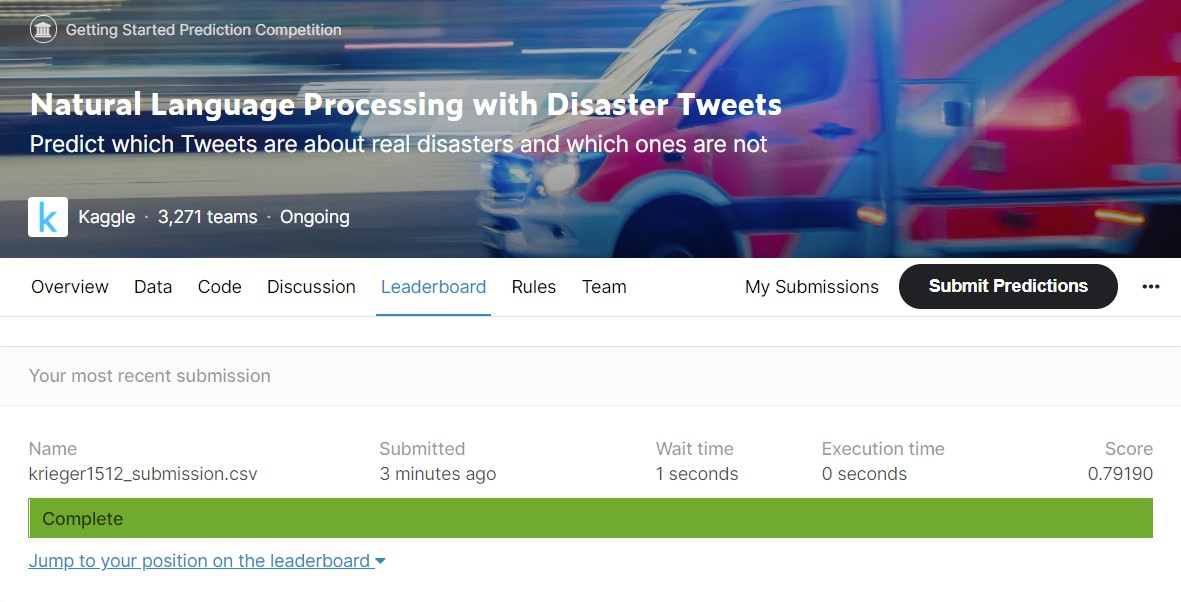

Our submission of the result model onto Kaggle confirmed our expectation. There our result model was applied on the exact same test dataset, with the only difference being this time the test set was classified by its creators themselves. Although the labels are not published, one can safely assume that they were much more correctly assigned in comparison to our own version. With this in mind, our combination of sentence-BERT and logistic regression achieved a final F1-score of 79.19%.

<a href='#0'>Back to ToC</a>

---
<a id='7'></a>
## 7. Conclusion

Other possible reasons for the low test F-0.5-Score are there being no hyperparameter tuning for the Logistic Regression classifier as well as only one training epoch for the Sentence-BERT embedder. In addition, the embedder was trained with inaccurate and incomplete samples. The fact that data was overfitted or Tweets were inadequately cleaned should also be considered. To solve these problems, one may use Random and Grid Search to optimize hyperparameters of the Logistic Regression classifier, increase the number of training epochs as well as preprocess the training samples of the Sentence-BERT embedder, apply stronger regularization to the result model or perform stricter data cleaning.

Furthermore, other embedding techniques (e.g. LSA) and classifiers (e.g. LSTM) may prove to be more effective. They should all be tried and analyzed.

<a href='#0'>Back to ToC</a>